In [1]:
# ## Cell 1: 모듈 임포트 및 기본 설정
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from collections import defaultdict

# --- 그래프 스타일 및 한글 폰트 설정 ---
sns.set_theme(style="whitegrid", palette="viridis")
try:
    plt.rcParams['font-family'] = 'AppleGothic' # macOS
except:
    try:
        plt.rcParams['font-family'] = 'Malgun Gothic' # Windows
    except:
        print("한글 폰트를 찾을 수 없습니다. 그래프의 한글이 깨질 수 있습니다.")
plt.rcParams['axes.unicode_minus'] = False
print("-" * 50)

한글 폰트를 찾을 수 없습니다. 그래프의 한글이 깨질 수 있습니다.
--------------------------------------------------


In [2]:
# ## Cell 2: 쌍대 비교 결과 데이터 로드
# 쌍대 비교 결과 파일 경로를 지정합니다.
# main.py 실행 후 생성된 `pairwise_results.jsonl` 파일의 경로를 사용하세요.
results_file = Path("../results/text/evaluation_results/pairwise_results.jsonl") # ⬅️ 실제 파일 경로로 수정하세요.

# --- JSONL 파일 로드 및 DataFrame 생성 ---
records = []
if results_file.exists():
    with open(results_file, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                records.append(json.loads(line))
            except json.JSONDecodeError:
                print(f"JSON 파싱 오류 발생, 다음 줄로 넘어갑니다: {line}")
else:
    print(f"오류: {results_file} 파일을 찾을 수 없습니다. 경로를 확인해주세요.")

pairwise_df = pd.DataFrame(records)

print("✅ 쌍대 비교 데이터 로딩 완료")
print(f"총 {len(pairwise_df)}개의 비교 결과가 로드되었습니다.")
pairwise_df.head()

✅ 쌍대 비교 데이터 로딩 완료
총 420개의 비교 결과가 로드되었습니다.


,question,page_id,model_A,model_B,winner,reason
0,AWS와 IDC 간의 VPN 터널링 연결 상태는 어떻게 되나요?,page_01,gpt-4o_M1,gpt-4o_M2,tie,"Both answers are identical, accurately stating..."
1,AWS와 IDC 간의 VPN 터널링 연결 상태는 어떻게 되나요?,page_01,gpt-4o_M1,gpt-4o_M3,tie,Both answers accurately state the VPN connecti...
2,AWS와 IDC 간의 VPN 터널링 연결 상태는 어떻게 되나요?,page_01,gpt-4o_M1,gpt-4o_M4,tie,Both answers accurately state the VPN connecti...
3,AWS와 IDC 간의 VPN 터널링 연결 상태는 어떻게 되나요?,page_01,gpt-4o_M1,gpt-4o_M5,B,"Answer B is more precise, directly quoting the..."
4,AWS와 IDC 간의 VPN 터널링 연결 상태는 어떻게 되나요?,page_01,gpt-4o_M1,gpt-4o_M6,tie,Both answers accurately state the VPN connecti...


In [3]:
# ## Cell 3: 승률 계산을 위한 데이터 전처리
# 'winner' 열을 기준으로 승리/패배/무승부 정보를 정리합니다.

# 'error'나 누락된 값을 제외하고 분석
pairwise_df.dropna(subset=['winner'], inplace=True)
pairwise_df = pairwise_df[pairwise_df['winner'] != 'error']

# 승리, 패배, 무승부 관계를 명확하게 정리
battles = []
for _, row in pairwise_df.iterrows():
    if row['winner'] == 'A':
        battles.append({'winner': row['model_A'], 'loser': row['model_B'], 'result': 'win'})
    elif row['winner'] == 'B':
        battles.append({'winner': row['model_B'], 'loser': row['model_A'], 'result': 'win'})
    elif row['winner'] == 'tie':
        battles.append({'winner': row['model_A'], 'loser': row['model_B'], 'result': 'tie'})
        battles.append({'winner': row['model_B'], 'loser': row['model_A'], 'result': 'tie'})

battles_df = pd.DataFrame(battles)
print("✅ 데이터 전처리 완료")
battles_df.head()

✅ 데이터 전처리 완료


,winner,loser,result
0,gpt-4o_M1,gpt-4o_M2,tie
1,gpt-4o_M2,gpt-4o_M1,tie
2,gpt-4o_M1,gpt-4o_M3,tie
3,gpt-4o_M3,gpt-4o_M1,tie
4,gpt-4o_M1,gpt-4o_M4,tie


In [4]:
# ## Cell 4: 모델별 종합 순위표 생성
# 각 모델의 총 승리, 패배, 무승부 횟수를 집계하여 종합 순위를 계산합니다.

# 승리 횟수 계산
wins = battles_df[battles_df['result'] == 'win']['winner'].value_counts().reset_index()
wins.columns = ['model', 'wins']

# 패배 횟수 계산
losses = battles_df[battles_df['result'] == 'win']['loser'].value_counts().reset_index()
losses.columns = ['model', 'losses']

# 무승부 횟수 계산
ties = battles_df[battles_df['result'] == 'tie']['winner'].value_counts().reset_index()
ties.columns = ['model', 'ties']

# 데이터 병합
summary_df = pd.merge(wins, losses, on='model', how='outer')
summary_df = pd.merge(summary_df, ties, on='model', how='outer')
summary_df.fillna(0, inplace=True) # NaN 값을 0으로 채움

# 총 경기 수 및 승률 계산
summary_df['total_matches'] = summary_df['wins'] + summary_df['losses'] + summary_df['ties']
# 패배하지 않을 확률 (승리 + 무승부)
summary_df['win_rate'] = (summary_df['wins'] + 0.5 * summary_df['ties']) / summary_df['total_matches']

# 승률 기준으로 정렬
summary_df = summary_df.sort_values(by='win_rate', ascending=False).reset_index(drop=True)

print("🏆 모델별 종합 성능 순위표")
print(summary_df)

🏆 모델별 종합 성능 순위표
       model  wins  losses  ties  total_matches  win_rate
0  gpt-4o_M6    16      10    94            120  0.525000
1  gpt-4o_M3    19      14    87            120  0.520833
2  gpt-4o_M4    21      17    82            120  0.516667
3  gpt-4o_M7    18      15    87            120  0.512500
4  gpt-4o_M1    19      21    80            120  0.491667
5  gpt-4o_M5    17      21    82            120  0.483333
6  gpt-4o_M2    13      25    82            120  0.450000


/Users/bagjimin/miniconda3/envs/vlm_test_py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bagjimin/miniconda3/envs/vlm_test_py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bagjimin/miniconda3/envs/vlm_test_py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bagjimin/miniconda3/envs/vlm_test_py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bagjimin/miniconda3/envs/vlm_test_py310/lib/python3.10/site-packages/IPython/

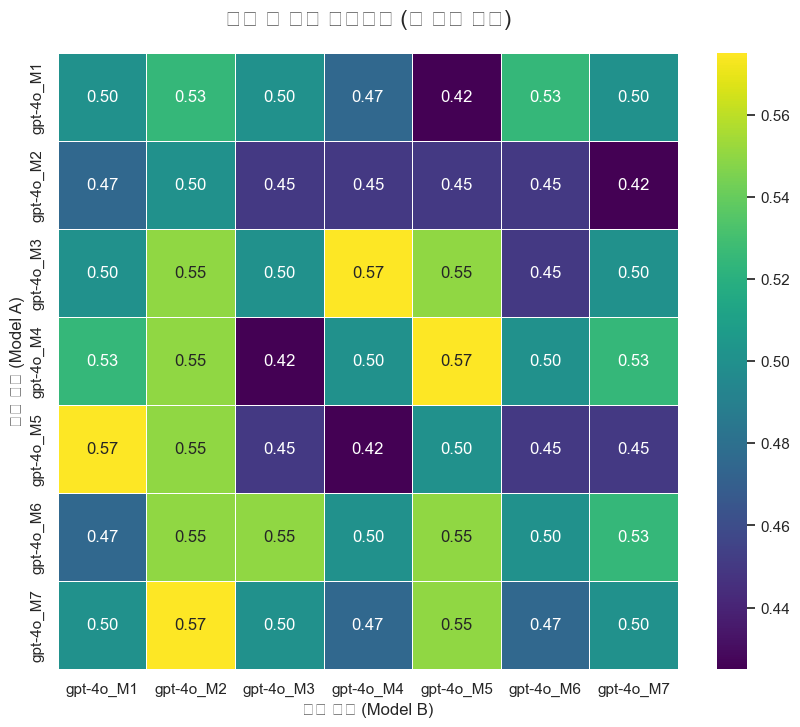

In [5]:
# ## Cell 5: 승률 매트릭스(Win-rate Matrix) 생성 및 시각화
# 어떤 모델이 다른 모델을 상대로 얼마나 높은 승률을 보이는지 히트맵으로 시각화합니다.

# 모든 모델 목록 가져오기
all_models = sorted(summary_df['model'].unique())
matrix = pd.DataFrame(np.nan, index=all_models, columns=all_models)

# 각 모델 쌍에 대한 승률 계산
for model_a in all_models:
    for model_b in all_models:
        if model_a == model_b:
            matrix.loc[model_a, model_b] = 0.5 # 자기 자신과는 50%
            continue
        
        # A가 B를 상대로 한 경기만 필터링
        pair_battles = pairwise_df[
            ((pairwise_df['model_A'] == model_a) & (pairwise_df['model_B'] == model_b)) |
            ((pairwise_df['model_A'] == model_b) & (pairwise_df['model_B'] == model_a))
        ]
        
        if len(pair_battles) == 0:
            continue

        wins_a = np.sum(
            ((pair_battles['model_A'] == model_a) & (pair_battles['winner'] == 'A')) |
            ((pair_battles['model_B'] == model_a) & (pair_battles['winner'] == 'B'))
        )
        ties = np.sum(pair_battles['winner'] == 'tie')
        
        win_rate_a = (wins_a + 0.5 * ties) / len(pair_battles)
        matrix.loc[model_a, model_b] = win_rate_a

# --- 시각화: 히트맵 ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    matrix,
    annot=True,
    fmt=".2f",
    cmap="viridis", # 승률이 높을수록 밝은 색
    linewidths=.5
)
plt.title('모델 간 승률 매트릭스 (행 모델 기준)', fontsize=16, pad=20)
plt.xlabel('상대 모델 (Model B)', fontsize=12)
plt.ylabel('기준 모델 (Model A)', fontsize=12)
plt.show()